In [1]:
import pandas as pd
import math
from google.cloud import storage


In [2]:
client = storage.Client(project="uk-election-406413")
bucket = client.bucket("ukelectiondata")
files = bucket.list_blobs()
file_names = [file.name for file in files]


In [4]:
election_results = bucket.blob("full_df.csv")
election_results.download_to_filename('C:\\Users\\wg4618\\Documents\\LeWagon\\full_data.csv')
election_results


<Blob: ukelectiondata, full_df.csv, 1701425639633759>

# Preparing Data

In [169]:
data = pd.read_csv('C:\\Users\\wg4618\\Documents\\LeWagon\\full_data.csv')
data.drop(data.columns[0], axis=1, inplace=True)
data.dropna(subset=['Cons_pre_GE_adjusted'], inplace=True)

data_raw = data[data['year'] != 2024].drop(columns="year")
data_new_raw = data[data['year'] == 2024].drop(columns="year")


X = data_raw[['Private_renters', 'Social_renters', 'Home_owners',
          '0-9', '10-19',
          '20-29', '30-39', '40-49', '50-59',
          '60-69', '70-79', '80+',
          'Asian', 'Black', 'Mixed', 'Other', 'White',
          #'conservative_vote_share_previous', 'labour_vote_share_previous',# 'liberal_democrats_vote_share_previous',
          #'Conservative_Pre_GE_poll', 'Labour_Pre_GE_poll', 'LD_Pre_GE_poll',
          'Cons_pre_GE_adjusted', 'Labs_pre_GE_adjusted', 'Libs_pre_GE_adjusted',
          #'Cons_pre_average_adjusted', 'Labs_pre_average_adjusted', 'Libs_pre_average_adjusted',
          #'Cons_pre_min_adjusted', 'Labs_pre_min_adjusted', 'Libs_pre_min_adjusted',
          #'Cons_pre_max_adjusted', 'Labs_pre_max_adjusted', 'Libs_pre_max_adjusted'
          ]]

X_new = data_new_raw[['Private_renters', 'Social_renters', 'Home_owners',
          '0-9', '10-19',
          '20-29', '30-39', '40-49', '50-59',
          '60-69', '70-79', '80+',
          'Asian', 'Black', 'Mixed', 'Other', 'White',
          #'conservative_vote_share_previous', 'labour_vote_share_previous', #'liberal_democrats_vote_share_previous',
          #'Conservative_Pre_GE_poll', 'Labour_Pre_GE_poll', 'LD_Pre_GE_poll',
          'Cons_pre_GE_adjusted', 'Labs_pre_GE_adjusted', 'Libs_pre_GE_adjusted',
          #'Cons_pre_average_adjusted', 'Labs_pre_average_adjusted', 'Libs_pre_average_adjusted',
          #'Cons_pre_min_adjusted', 'Labs_pre_min_adjusted', 'Libs_pre_min_adjusted',
          #'Cons_pre_max_adjusted', 'Labs_pre_max_adjusted', 'Libs_pre_max_adjusted'
          ]]

#X_new['Libs_pre_GE_adjusted'] = X_new['Libs_pre_GE_adjusted']*2

y = data_raw[['conservative_votes', 'labour_votes', 'liberal_democrats_votes']]#, 'other_parties_votes']]


In [58]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
#data.columns


In [170]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pca = PCA(n_components=8)  # Choose the number of components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_new_pca = pca.transform(X_new)


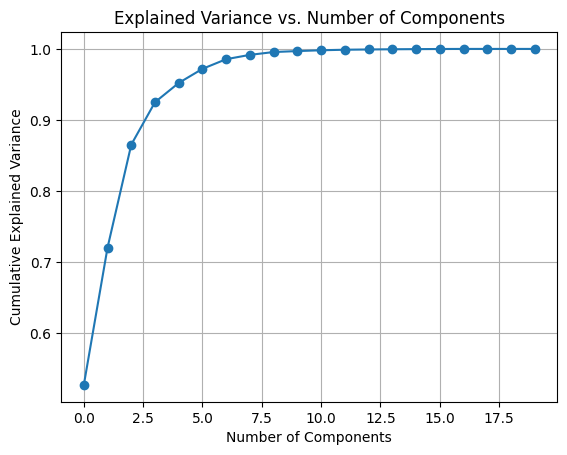

In [152]:
pca = PCA()
pca.fit(X)

# Plot cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [153]:
from pandas.plotting import scatter_matrix
import seaborn as sns


# Ridge Regression Model

### Grid search

In [155]:
# Create and fit a Linear Regression model
alphas = {'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1]}

ridge = Ridge()
grid_search = GridSearchCV(ridge, alphas, cv=5)
grid_search.fit(X_train, y_train)
display(grid_search.cv_results_['mean_test_score'])

X_train.columns


array([0.81513075, 0.81573184, 0.81590692, 0.81585311, 0.81587743,
       0.81584059, 0.81215148])

Index(['Private_renters', 'Social_renters', 'Home_owners', '0-9', '10-19',
       '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'Asian',
       'Black', 'Mixed', 'Other', 'White', 'Cons_pre_GE_adjusted',
       'Labs_pre_GE_adjusted', 'Libs_pre_GE_adjusted'],
      dtype='object')

### Running and scoring the best model

In [156]:
best_alpha = grid_search.best_params_['alpha']
print("Best alpha: ", best_alpha)

final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coefficients:", final_model.coef_)
print("Intercept:", final_model.intercept_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

coefficients_named = pd.DataFrame({"con" : final_model.coef_[0],
                                   "lab" : final_model.coef_[1],
                                   "ld" : final_model.coef_[2],
                                   }, index=X_train.columns)
display(final_model.intercept_)
display(coefficients_named)


Best alpha:  1e-05
Coefficients: [[-2.63479755e+03 -4.42649867e+03  7.06129625e+03 -3.26227962e+04
  -3.50288787e+04 -3.33461068e+04 -3.69420383e+03 -3.61090313e+04
  -4.94199120e+03 -7.72312998e+04  4.00284716e+04 -1.05470997e+05
   6.01559710e+03  1.15135182e+04 -5.01528748e+03 -1.79886910e+04
   5.47014997e+03  4.14325549e+04 -1.34913057e+04 -9.36991303e+02]
 [ 8.04741753e+03 -9.44355944e+03  1.39614190e+03 -1.39604184e+05
   1.40602084e+04 -4.87835839e+04  3.28767804e+04 -1.13643014e+05
   3.35224517e+04 -9.24079381e+04 -3.07328009e+04 -7.31219548e+04
   8.70569486e+03  1.42613007e+04  2.60214933e+04 -4.93173891e+04
   3.44777252e+02  7.21436810e+03  4.56198229e+04 -2.16505298e+03]
 [ 2.11248568e+03 -2.17687882e+02 -1.89479779e+03  2.69106427e+05
   3.52805082e+05  2.97427451e+05  3.35384777e+05  3.48986545e+05
   3.03801774e+05  3.00856095e+05  2.71683550e+05  3.69093089e+05
  -6.70787230e+02 -3.66733306e+03  1.47422372e+04 -1.07425033e+04
   3.40223334e+02 -2.88303714e+03 -1.0616

array([  29395.47096105,   42229.87545972, -308128.82679481])

,con,lab,ld
Private_renters,-2634.797547,8047.417527,2112.485685
Social_renters,-4426.498675,-9443.559438,-217.687882
Home_owners,7061.296250,1396.141905,-1894.797788
0-9,-32622.796236,-139604.183927,269106.426848
10-19,-35028.878722,14060.208418,352805.082304
20-29,-33346.106788,-48783.583943,297427.451298
30-39,-3694.203833,32876.780415,335384.777218
40-49,-36109.031313,-113643.014094,348986.544733
50-59,-4941.991202,33522.451679,303801.774385
60-69,-77231.299750,-92407.938069,300856.094773


### Plotting the test data against the predicted data

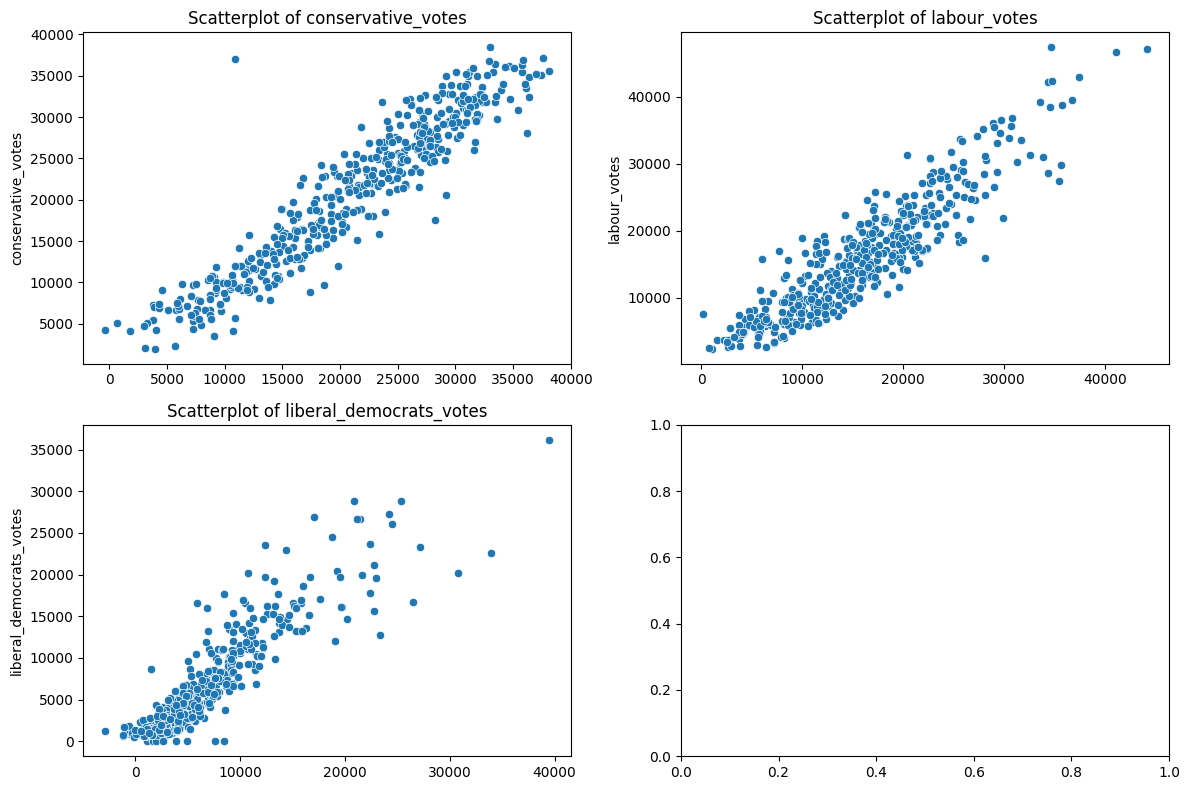

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over columns and create subplots
for i in range(3):
    sns.scatterplot(x=y_pred[:,i], y=y_test.iloc[:,i], ax=axes[i])
    axes[i].set_title(f'Scatterplot of {y_test.columns[i]}')

# Adjust layout
plt.tight_layout()

# Show the plots
#plt.show()


### Predicting the next election using Ridge Regression

In [158]:
final_model.predict(X_new)


array([[ 5853.70677315, 32473.85616711,  -947.23406525],
       [13900.4821758 , 25367.91235399,   790.59732106],
       [20937.51173222, 17610.06170444,  7575.46565513],
       ...,
       [13033.15961775, 17499.61624455,   661.33578402],
       [ 6173.02968957, 37001.89504131, -1938.14961016],
       [16808.47550592, 21190.90280206,  6475.91577569]])

In [159]:
import numpy as np
y_new = final_model.predict(X_new)

unique_values, counts = np.unique(np.argmax(y_new, axis=1), return_counts=True)
frequency_table = pd.DataFrame({'Value': unique_values, 'Frequency': counts})

frequency_table


,Value,Frequency
0,0,223
1,1,342
2,2,8


In [160]:
import shap

explainer = shap.KernelExplainer(model=final_model.predict, data=X_test)

# Calculate SHAP values for a sample of the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


Using 456 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/456 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Gradient Boosting Classifier

### Turning y into a class and encoding it

In [86]:
from sklearn.preprocessing import LabelEncoder

y_train_class = y_train.apply(lambda row: row.idxmax(), axis=1)
y_test_class = y_test.apply(lambda row: row.idxmax(), axis=1)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_class)
y_test_encoded = label_encoder.fit_transform(y_test_class)


### Grid Search 

In [104]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

gb_classifier = GradientBoostingClassifier()

param_grid = {'n_estimators': [80, 100],
    'learning_rate': [0.1, 0.5],
    'max_depth': [6, 7]}

grid_search_tree = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search_tree.fit(X_train_pca, y_train_encoded)
print("Best Hyperparameters:", grid_search_tree.best_params_)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


### Running and scoring the best model

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#best_model_gb = grid_search_tree.best_estimator_
#best_model_gb.fit(X_train, y_train_encoded)
#y_pred_tree = best_model_gb.predict(X_test)

best_model_gb = grid_search_tree.best_estimator_
best_model_gb.fit(X_train_pca, y_train_encoded)
y_pred_tree = best_model_gb.predict(X_test_pca)

classification_rep = classification_report(y_test_encoded, y_pred_tree)
print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       273
           1       0.89      0.89      0.89       167
           2       0.53      0.56      0.55        16

    accuracy                           0.90       456
   macro avg       0.78      0.79      0.79       456
weighted avg       0.90      0.90      0.90       456



### Predicting the next election using Boosted Tree

In [110]:
y_new_tree = best_model_gb.predict(X_new_pca)

unique_values, counts = np.unique(y_new_tree, return_counts=True)

frequency_table = np.column_stack((unique_values, counts))

unique_values, counts = np.unique(y_new_tree, return_counts=True)
frequency_table = pd.DataFrame({'Value': unique_values, 'Frequency': counts})

frequency_table


,Value,Frequency
0,0,219
1,1,338
2,2,16


In [66]:
import shap

explainer = shap.TreeExplainer(best_model_gb)

# Calculate SHAP values for a sample of the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


InvalidModelError: GradientBoostingClassifier is only supported for binary classification right now!

# Gradient Boosting Regression

In [175]:
data


,Constituency,ONSConstID,year,Home_owners,Private_renters,Social_renters,0-9,10-19,20-29,30-39,...,Libs_pre_GE_adjusted,Cons_pre_max_adjusted,Labs_pre_max_adjusted,Libs_pre_max_adjusted,Cons_pre_min_adjusted,Labs_pre_min_adjusted,Libs_pre_min_adjusted,Cons_pre_average_adjusted,Labs_pre_average_adjusted,Libs_pre_average_adjusted
0,Aberavon,W07000049,2010,0.644274,0.151463,0.204263,0.1096,0.1164,0.1227,0.1266,...,0.161295,0.138857,0.653968,0.161295,0.089831,0.371864,0.082509,0.116178,0.518513,0.113700
1,Aberavon,W07000049,2015,0.659775,0.136265,0.203960,0.1128,0.1095,0.1232,0.1293,...,0.057296,0.155969,0.746012,0.186384,0.108269,0.489789,0.051083,0.129599,0.669348,0.071532
2,Aberavon,W07000049,2017,0.667525,0.128666,0.203809,0.1133,0.1126,0.1194,0.1337,...,0.047101,0.139208,0.497438,0.059019,0.102574,0.382304,0.036887,0.119728,0.443902,0.045552
3,Aberavon,W07000049,2019,0.675276,0.121067,0.203657,0.1118,0.1152,0.1187,0.1330,...,0.036660,0.172853,0.688903,0.048631,0.087434,0.361753,0.015711,0.150836,0.567896,0.025518
4,Aberavon,W07000049,2024,0.683026,0.113468,0.203506,0.1100,0.1170,0.1210,0.1330,...,0.032447,0.229343,0.785617,0.036053,0.105920,0.443912,0.020129,0.162275,0.595796,0.027222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,York Outer,E14001062,2010,0.801490,0.110718,0.087792,0.0999,0.1275,0.1058,0.1028,...,0.280305,0.704779,0.266181,0.280305,0.455942,0.151358,0.143387,0.589672,0.211047,0.197592
2848,York Outer,E14001062,2015,0.812853,0.101377,0.085770,0.1003,0.1229,0.1139,0.0993,...,0.127087,0.470553,0.245538,0.413414,0.326646,0.161206,0.113306,0.390998,0.220305,0.158664
2849,York Outer,E14001062,2017,0.818535,0.096706,0.084759,0.0994,0.1286,0.1107,0.0987,...,0.123609,0.576026,0.251883,0.154884,0.424440,0.193583,0.096802,0.495423,0.224774,0.119542
2850,York Outer,E14001062,2019,0.824216,0.092035,0.083748,0.0973,0.1302,0.1138,0.0979,...,0.209539,0.498149,0.371000,0.277960,0.251978,0.194817,0.089803,0.434696,0.305833,0.145854


In [171]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Assuming you have X_train_pca and y_train defined

gb_regressor = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [80, 100],
    'learning_rate': [0.1, 0.5],
    'max_depth': [6, 7]
}

grid_search_tree_reg = GridSearchCV(
    estimator=gb_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search_tree_reg.fit(X_train_pca, y_train)
print("Best Hyperparameters:", grid_search_tree_reg.best_params_)


ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 424, in fit
    y = column_or_1d(y, warn=True)
  File "/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1244, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (1458, 3) instead.

--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 424, in fit
    y = column_or_1d(y, warn=True)
  File "/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1244, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (1459, 3) instead.


# K Nearest Neighbours

### Grid search

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn_classifier = KNeighborsClassifier()  # You can adjust the number of neighbors (k) as needed

param_grid_knn = {'n_neighbors': [3,4,5,6,7,8]}

grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid_knn, scoring='f1_macro', cv=5)

# Fit the model to the training data
grid_search_knn.fit(X_train, y_train_encoded)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8]},
             scoring='f1_macro')

### Running and scoring the best model

In [68]:
# Make predictions on the test set
best_model_knn = grid_search_knn.best_estimator_
best_model_knn.fit(X_train, y_train_encoded)
y_pred_knn = best_model_knn.predict(X_test)

classification_rep = classification_report(y_test_encoded, y_pred_knn)

print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       273
           1       0.90      0.88      0.89       167
           2       0.54      0.44      0.48        16

    accuracy                           0.89       456
   macro avg       0.78      0.75      0.76       456
weighted avg       0.89      0.89      0.89       456



### Predicting the next election using KNN

In [69]:
y_new_knn = best_model_knn.predict(X_new)

unique_values, counts = np.unique(y_new_knn, return_counts=True)

frequency_table = np.column_stack((unique_values, counts))

unique_values, counts = np.unique(y_new_knn, return_counts=True)
frequency_table = pd.DataFrame({'Value': unique_values, 'Frequency': counts})

frequency_table


,Value,Frequency
0,0,222
1,1,332
2,2,19


In [28]:
import shap
shap.initjs();

# Step 1: Create a SHAP Explainer
explainer = shap.Explainer(best_model_knn) # put the model

# Step 2: Calculate the SHAP values
shap_values_one = explainer(X_train.columns)

print(f"{'Base value:':<35}{shap_values_one.base_values[0]:>7.3f}")
print(f"{'Sum of SHAP values:':<35}{shap_values_one.values.sum():>7.3f}")
#print(f"{'The prediction for this instance:':<35}{prediction[0]:>7.3f}")

shap.plots.bar(shap_values_one[0])


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsClassifier(n_neighbors=7)

# SVC 

### Grid search

In [70]:
from sklearn.svm import SVC

svc_classifier = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],        # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto'],    # Kernel coefficient
}

grid_search_svc = GridSearchCV(estimator=svc_classifier, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search_svc.fit(X_train, y_train_encoded)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

### Running and scoring the best model

In [71]:
best_svc = grid_search_svc.best_estimator_

best_svc.fit(X_train, y_train_encoded)

y_pred_svc = best_svc.predict(X_test)

classification_rep = classification_report(y_test_encoded, y_pred_svc)

print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       273
           1       0.90      0.91      0.91       167
           2       0.62      0.50      0.55        16

    accuracy                           0.91       456
   macro avg       0.82      0.78      0.80       456
weighted avg       0.91      0.91      0.91       456



### Predicting the next election using SVC

In [72]:
y_new_SVC = best_svc.predict(X_new)

unique_values, counts = np.unique(y_new_SVC, return_counts=True)

frequency_table = np.column_stack((unique_values, counts))

unique_values, counts = np.unique(y_new_SVC, return_counts=True)
frequency_table = pd.DataFrame({'Value': unique_values, 'Frequency': counts})

frequency_table


,Value,Frequency
0,0,194
1,1,345
2,2,34
